Вариантс2. [Набор данных для анализа и прогнозирования сердечного приступа](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease)

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../data/heart_2022_no_nans.csv')

In [3]:
df.info()
df.describe().transpose()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246022 entries, 0 to 246021
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      246022 non-null  object 
 1   Sex                        246022 non-null  object 
 2   GeneralHealth              246022 non-null  object 
 3   PhysicalHealthDays         246022 non-null  float64
 4   MentalHealthDays           246022 non-null  float64
 5   LastCheckupTime            246022 non-null  object 
 6   PhysicalActivities         246022 non-null  object 
 7   SleepHours                 246022 non-null  float64
 8   RemovedTeeth               246022 non-null  object 
 9   HadHeartAttack             246022 non-null  object 
 10  HadAngina                  246022 non-null  object 
 11  HadStroke                  246022 non-null  object 
 12  HadAsthma                  246022 non-null  object 
 13  HadSkinCancer              24

count       mean        std    min    25%    50%  \
PhysicalHealthDays  246022.0   4.119026   8.405844   0.00   0.00   0.00   
MentalHealthDays    246022.0   4.167140   8.102687   0.00   0.00   0.00   
SleepHours          246022.0   7.021331   1.440681   1.00   6.00   7.00   
HeightInMeters      246022.0   1.705150   0.106654   0.91   1.63   1.70   
WeightInKilograms   246022.0  83.615179  21.323156  28.12  68.04  81.65   
BMI                 246022.0  28.668136   6.513973  12.02  24.27  27.46   

                      75%     max  
PhysicalHealthDays   3.00   30.00  
MentalHealthDays     4.00   30.00  
SleepHours           8.00   24.00  
HeightInMeters       1.78    2.41  
WeightInKilograms   95.25  292.57  
BMI                 31.89   97.65

In [4]:
df_cleaned = df.drop(columns=list(filter(lambda x: not pd.api.types.is_numeric_dtype(df[x]), df.columns)))
df_cleaned['MentalHealthDays'].unique()

array([ 0., 15.,  4., 25.,  5., 30., 27.,  3.,  2.,  1., 10., 20., 21.,
        6.,  7.,  8., 14.,  9., 12., 18., 29., 28., 17., 11., 16., 13.,
       26., 22., 24., 19., 23.])

Создадим лингвистические переменные

Входные:
- SleepHours - количество часов сна
- BMI - индекс массы тела

Выходные:
- HadStroke - наличие сердечного приступа

In [5]:
import numpy as np
from skfuzzy import control as ctrl

sleep = ctrl.Antecedent(np.arange(df["SleepHours"].min(), df["SleepHours"].max() + 1, 1), "SleepHours")
bmi = ctrl.Antecedent(np.arange(df["BMI"].min(), df["BMI"].max() + 0.1, 0.1), "BMI")
had_stroke = ctrl.Consequent(np.arange(0, 1 + 0.01, 0.01), "HadStroke")


Произведем настройку

/home/nspotapov/ulstu/AIM-PIbd-31-Potapov-N-S/lab_7/.venv/lib/python3.12/site-packages/skfuzzy/control/fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


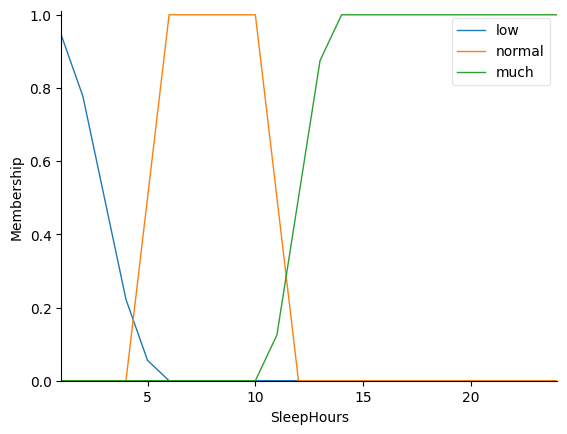

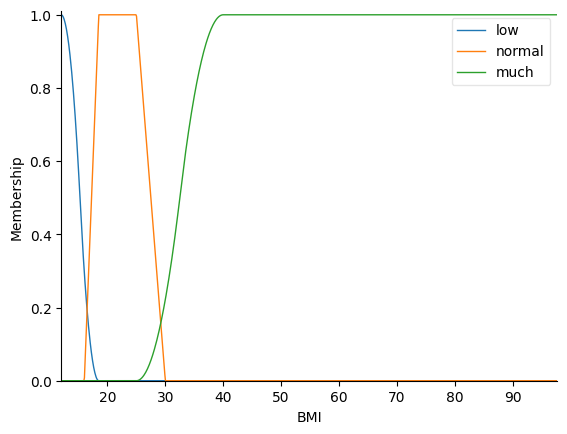

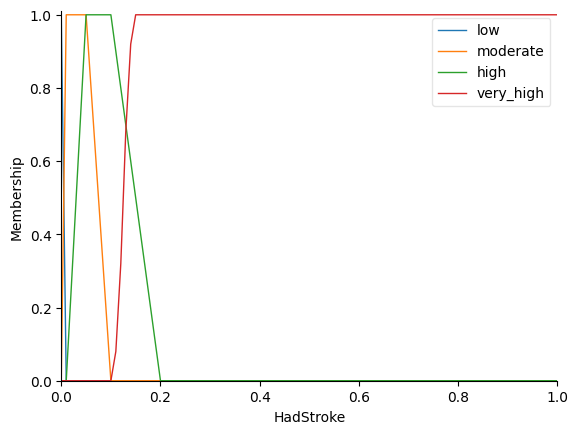

In [6]:
import skfuzzy as fuzz

sleep["low"] = fuzz.zmf(sleep.universe, 0, 6)
sleep["normal"] = fuzz.trapmf(sleep.universe, [4, 6, 10, 12])
sleep["much"] = fuzz.smf(sleep.universe, 10, 14)
sleep.view()

bmi["low"] = fuzz.zmf(bmi.universe, 12, 18.5)
bmi["normal"] = fuzz.trapmf(bmi.universe, [16, 18.5, 25, 30])
bmi["much"] = fuzz.smf(bmi.universe, 25, 40)
bmi.view()

# Определение функций принадлежности для had_stroke
had_stroke["low"] = fuzz.zmf(had_stroke.universe, 0, 0.01)  # Низкая вероятность (менее 1%)
had_stroke["moderate"] = fuzz.trapmf(had_stroke.universe, [0.005, 0.01, 0.05, 0.1])  # Умеренная вероятность (1% - 5%)
had_stroke["high"] = fuzz.trapmf(had_stroke.universe, [0.01, 0.05, 0.1, 0.2])  # Высокая вероятность (5% - 10%)
had_stroke["very_high"] = fuzz.smf(had_stroke.universe, 0.1, 0.15)  # Очень высокая вероятность (более 10%)

# Визуализация функций принадлежности
had_stroke.view()


Сформируем базу нечетких правил

Объяснение правил:

Правило 1: Если часы сна низкие (low) и ИМТ низкий (low), то вероятность сердечного приступа низкая (low).

Правило 2: Если часы сна низкие (low) и ИМТ нормальный (normal), то вероятность сердечного приступа умеренная (moderate).

Правило 3: Если часы сна низкие (low) и ИМТ высокий (much), то вероятность сердечного приступа высокая (high).

Правило 4: Если часы сна нормальные (normal) и ИМТ низкий (low), то вероятность сердечного приступа низкая (low).

Правило 5: Если часы сна нормальные (normal) и ИМТ нормальный (normal), то вероятность сердечного приступа низкая (low).

Правило 6: Если часы сна нормальные (normal) и ИМТ высокий (much), то вероятность сердечного приступа умеренная (moderate).

Правило 7: Если часы сна высокие (much) и ИМТ низкий (low), то вероятность сердечного приступа низкая (low).

Правило 8: Если часы сна высокие (much) и ИМТ нормальный (normal), то вероятность сердечного приступа низкая (low).

Правило 9: Если часы сна высокие (much) и ИМТ высокий (much), то вероятность сердечного приступа умеренная (moderate).



In [7]:
rules = [
    ctrl.Rule(sleep['low'] & bmi['low'], had_stroke['low']),
    ctrl.Rule(sleep['low'] & bmi['normal'], had_stroke['moderate']),
    ctrl.Rule(sleep['low'] & bmi['much'], had_stroke['high']),
    ctrl.Rule(sleep['normal'] & bmi['low'], had_stroke['low']),
    ctrl.Rule(sleep['normal'] & bmi['normal'], had_stroke['low']),
    ctrl.Rule(sleep['normal'] & bmi['much'], had_stroke['moderate']),
    ctrl.Rule(sleep['much'] & bmi['low'], had_stroke['low']),
    ctrl.Rule(sleep['much'] & bmi['normal'], had_stroke['low']),
    ctrl.Rule(sleep['much'] & bmi['much'], had_stroke['moderate']),
]

Создадим нечеткую систему и добавим созданные нечеткие правила в ее базу знаний

/home/nspotapov/ulstu/AIM-PIbd-31-Potapov-N-S/lab_7/.venv/lib/python3.12/site-packages/skfuzzy/control/controlsystem.py:135: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


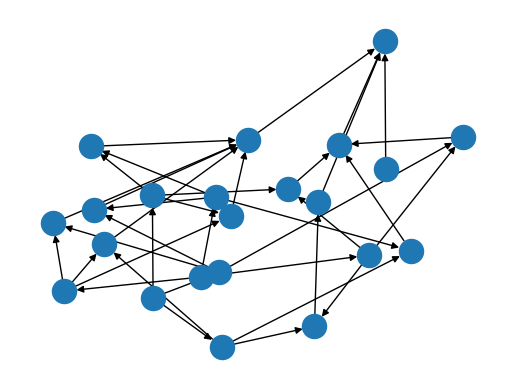

In [8]:
# Создание системы управления и добавление правил
stroke_ctrl = ctrl.ControlSystem(rules)

# Создание симуляции
stroke_simulation = ctrl.ControlSystemSimulation(stroke_ctrl)

# Теперь можно визуализировать правила
stroke_ctrl.view()

In [9]:
stroke_simulation.input['SleepHours'] = 5  # Пример входного значения
stroke_simulation.input['BMI'] = 22        # Пример входного значения
stroke_simulation.compute()
stroke_simulation.print_state()
stroke_p = stroke_simulation.output['HadStroke']
print(stroke_p)

 Antecedents 
Antecedent: SleepHours              = 5
  - low                             : 0.05555555555555555
  - normal                          : 0.5
  - much                            : 0.0
Antecedent: BMI                     = 22
  - low                             : 0.0
  - normal                          : 1.0
  - much                            : 0.0

 Rules 
RULE #0:
  IF SleepHours[low] AND BMI[low] THEN HadStroke[low]
	AND aggregation function : fmin
	OR aggregation function  : fmax

  Aggregation (IF-clause):
  - SleepHours[low]                                        : 0.05555555555555555
  - BMI[low]                                               : 0.0
                              SleepHours[low] AND BMI[low] = 0.0
  Activation (THEN-clause):
                                            HadStroke[low] : 0.0

RULE #1:
  IF SleepHours[low] AND BMI[normal] THEN HadStroke[moderate]
	AND aggregation function : fmin
	OR aggregation function  : fmax

  Aggregation (IF-clause):
 

Визуализация функции принадлежности для выходной переменной had_stroke

Функция получена в процессе аккумуляции и используется для дефаззификации значения выходной переменной had_stroke

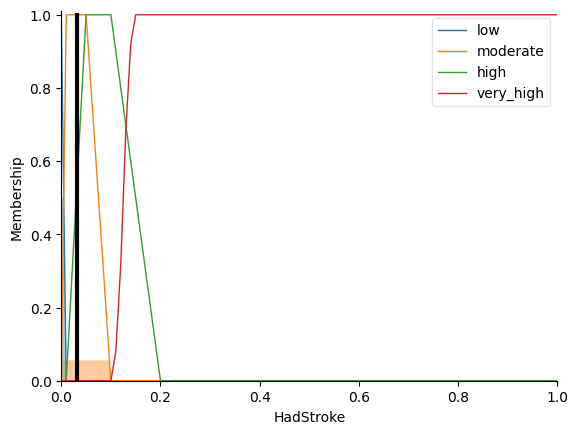

In [10]:
had_stroke.view(sim=stroke_simulation)

Сравним результаты работы системы с реальными данными

In [11]:
def fuzzy_pred(row):
    stroke_simulation.input["SleepHours"] = row["SleepHours"]
    stroke_simulation.input["BMI"] = row["BMI"]
    stroke_simulation.compute()
    return stroke_simulation.output["HadStroke"]

In [16]:
result = df.copy()
result = result.sample(frac=0.01)
result["HadStrokePredicted"] = result.apply(fuzzy_pred, axis=1)
result["HadStroke"] = result.apply(lambda x: 1 if x["HadStroke"] == 'Yes' else 0, axis=1)
result.loc[:, ["SleepHours", "BMI", "HadStroke", "HadStrokePredicted"]]

SleepHours    BMI  HadStroke  HadStrokePredicted
231476         8.0  23.03          0            0.003333
236378         8.0  30.68          0            0.047222
109247         5.0  33.82          0            0.057174
69198          8.0  24.39          0            0.003333
133337         7.0  24.84          0            0.003333
...            ...    ...        ...                 ...
93935          7.0  24.03          0            0.003333
218410         9.0  31.32          0            0.046591
100042         6.0  30.41          0            0.047472
58400          8.0  31.01          0            0.046903
35904          6.0  20.94          0            0.003333

[2460 rows x 4 columns]

Оценим эти результаты с помощью метрик для задачи регрессии

In [20]:
import math
from sklearn import metrics

rmetrics = {}
rmetrics["RMSE"] = math.sqrt(
    metrics.mean_squared_error(result["HadStroke"], result["HadStrokePredicted"])
)
rmetrics["RMAE"] = math.sqrt(
    metrics.mean_absolute_error(result["HadStroke"], result["HadStrokePredicted"])
)
rmetrics["R2"] = metrics.r2_score(
    result["HadStroke"], result["HadStrokePredicted"]
)

rmetrics

{'RMSE': 0.1888734235934381,
 'RMAE': 0.251645328415333,
 'R2': -0.0013951099998465999}

Вывод

Значение RMSE=0.1889 может считаться относительно небольшим, но его интерпретация зависит от масштаба данных. Если целевая переменная (например, вероятность сердечного приступа) находится в диапазоне от 0 до 1, то ошибка в 0.1889 может быть значительной.

Значение RMAE=0.2516 также указывает на значительные ошибки в предсказаниях. Это подтверждает, что модель плохо справляется с задачей.

Отрицательное значение R² (-0.0014) указывает на то, что модель работает хуже, чем простое предсказание среднего значения целевой переменной. Это явный признак того, что модель не подходит для данных.

Заключение

Исходя из оценок, модель неэффективна для предсказания сердечного приступа на основе выбранных признаков. Необходимо пересмотреть подход к построению модели, улучшить данные и, возможно, использовать более подходящие методы машинного обучения.